In [57]:
# TODO add utils (for like IO / data handling) specific to melody generation

from enum import Enum
from os import walk, listdir
import os.path

from tqdm import tqdm
from music21.note import Note, Rest
from music21.pitch import Pitch
from music21.duration import Duration
from music21.tempo import MetronomeMark

from simplemelodygen.extensions import MultiInstanceTrainableMarkovChainMelodyGenerator


class Columns(Enum):
    Sira = 0
    Kod = 1
    Nota53 = 2
    NotaAE = 3
    Koma53 = 4
    KomaAE = 5
    Pay = 6
    Payda = 7
    Ms = 8
    LNS = 9
    Bas = 10
    Soz1 = 11
    Offset = 12


CODE_NOTE = 9
CODE_REST = "Es"
OneCommaInCents = 21.51 # according to Wikipedia
TRAINING_MAKAM = "hicaz"

SYMBTR_TXT_FOLDER = "/Users/sercanatli/Workspaces/SymbTr/txt"


def parse_symbtr_txt(filename):
    '''Parses given symbtr, returns music21 (Note, Duration)'''

    note_list = []
    # tempo (can be used later)
    bpm = None
    
    file = open(filename)
    for index, line in enumerate(file):
        if (index == 0):
            continue

        split_line = line.strip().split("\t")

        # time signature
        ts_num=None
        ts_denum=None
        if (index == 1):
            ts_num = int(split_line[Columns.Pay.value])
            ts_denum = int(split_line[Columns.Payda.value])

        # reading notes
        if (int(split_line[Columns.Kod.value])) == CODE_NOTE:
            parsed_note = split_line[Columns.NotaAE.value]
    
            # note name
            note_name = parsed_note[:2]
            accidental = None
    
            if (len(parsed_note) > 2):
                parsed_note_for_accidental = split_line[Columns.Nota53.value]
                accidental = parsed_note_for_accidental[-2:]        
    
            # note length
            pay = int(split_line[Columns.Pay.value])
            payda = int(split_line[Columns.Payda.value])

            if pay == 1 and payda == 4 and bpm == None:
                bpm = 60000 / int(split_line[Columns.Ms.value])
                
            # calculate microtone
            if (accidental):
                signature = 1 if accidental[0] == "#" else -1
                microtone = signature * int(accidental[1]) * OneCommaInCents

            if (parsed_note == CODE_REST):
                note = Rest()
            else:
                note = Pitch(step=parsed_note[0], 
                             octave=int(parsed_note[1]),
                             accidental=None,
                             microtone=microtone if accidental else None)

            duration = Duration()
            duration.quarterLength = (pay/payda) / (1/4)
            note_list.append((note, duration))
    file.close()
    
    return note_list


def parse_symbtr_corpus(makam):
    parsed_data = []
    states = set()
    makam_pitches = set()

    scores = [symbtr for symbtr in listdir(SYMBTR_TXT_FOLDER) if symbtr.split("--")[0] == makam]
    composition_count = 0
    note_count = 0
    
    for score_file in tqdm(scores):
        composition_count += 1
        note_list = parse_symbtr_txt(os.path.join(SYMBTR_TXT_FOLDER, score_file))
        
        for note_pair in note_list:
            note_count += 1
            makam_pitches.add(note_pair[0])
            states.add((note_pair[0].nameWithOctave if note_pair[0].name != "rest" else "Rest", note_pair[1].quarterLength))
        
        parsed_data.append(note_list)

    print("For {0} in total {1} compositions and {2} notes".format(TRAINING_MAKAM, composition_count, note_count))
    return parsed_data, states, makam_pitches

def train_model(parsed_makam_data, states):
    training_data=[]
    for composition in parsed_makam_data:
        note_list = []
        note = None
    
        for pitch, duration in composition:
            if (pitch.name == "rest"):
                note = Rest(duration=duration)
            else:
                note = Note(pitch, duration=duration)

            if (note):
                note_list.append(note)

        training_data.append(note_list)
    
    model = MultiInstanceTrainableMarkovChainMelodyGenerator(list(states))
    model.train(training_data)

    return model


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 394.20it/s]


For hicaz in total 157 compositions and 64067 notes


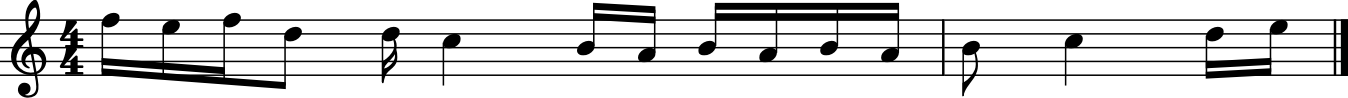

CPU times: user 1.3 s, sys: 46.6 ms, total: 1.35 s
Wall time: 2.67 s


'/Users/sercanatli/Desktop/output_generated.mid'

In [58]:
%%time

parsed_makam_data, states, makam_pitches = parse_symbtr_corpus(TRAINING_MAKAM)
makam_model = train_model(parsed_makam_data, states)
generated_melody, _ = model.generate(16)

from music21 import stream

score = stream.Score()
part = stream.Part()

for note in generated_melody:
    for pitch in list(makam_pitches):
        if pitch.name == "rest":
            continue
        elif note[0] == "Rest":
            part.append(Rest(note[1]))
            break
        elif note[0] == pitch.nameWithOctave:
            part.append(Note(pitch, quarterLength=note[1]))
            break

score.append(part)
score.show('midi')
score.show()

output_path = "/Users/sercanatli/Desktop/output_generated.mid"
score.write('midi', fp=output_path)